In [1]:
import requests
import bs4
import scipy.io as scio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [151]:
import numpy as np
import pandas as pd
import progressbar
from sklearn import cross_validation as cv
from sklearn.model_selection import train_test_split
import random
from surprise import NMF
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import BaselineOnly
from surprise import NormalPredictor
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

# 一些需要调用的函数

In [3]:
path = "C:/Users/wkl31415926/OneDrive/Projects/CPRS/process/"

### 将一个matrix转为DataSet格式(没有值的地方为NaN)

In [4]:
def matrix_to_col_dataSet(matrix, reader):
    ret = []
    for idx_r,r in enumerate(matrix):
        for idx_c,c in enumerate(r):
            if not np.isnan(c):
                ret.append([idx_r,idx_c,c])
    ret = pd.DataFrame(ret)
    ret.columns = ['userID', 'itemID', 'rating']
    return Dataset.load_from_df(ret[['userID', 'itemID', 'rating']], reader)

## 爬虫部分

### 对于题目难度的估价

In [5]:
def hardness(problemid,score,solvetime):
    if solvetime == None:
        return np.nan
    solvetime = int(solvetime[:2])*60+int(solvetime[3:])
    return int(solvetime)


### 获取某个页面的数据

In [6]:
def getTab(url):
    r = requests.get(url)
    soup = bs4.BeautifulSoup(r.text,'lxml')
    datas = []
    ptitle = []
    for ths in  soup.tr("th")[4:]:
        ptitle += [ths.a["title"][4:]]
    
    for tr in soup(participantid = True):
        tds = tr("td")
        ret = []
        ret += [tds[1].get_text(strip=True)]
        ret += [int(tds[2].get_text(strip=True))]
        ret += [tds[3].get_text(strip=True)+""]
        for i in range(4,len(tds)):
            ret += [hardness(i,
                            tds[i](class_="cell-passed-system-test")[0].get_text(strip=True) 
                            if len(tds[i](class_="cell-passed-system-test")) != 0 
                            else None,
                            tds[i](class_="cell-time")[0].get_text(strip=True) 
                            if len(tds[i](class_="cell-time")) !=0 
                            else None )]
        datas += [ret]
    
    for j, line in enumerate(datas):
        temp = []
        for i in range(3,3+len(ptitle)):
            if not np.isnan(line[i]):
                temp += [[i,line[i]]]
        temp = sorted(temp, key=lambda x:x[1] )
        for i in reversed(range(1,len(temp))):
            temp[i][1]-=temp[i-1][1]
        for item in temp:
            line[item[0]]=item[1]
        datas[j] = line

    return datas,ptitle

### 获取一场比赛的所有数据 传入比赛id

In [7]:
# contest id
def getAll(contest_id):
    print("starting to get Contest "+str(contest_id))
    url = "http://codeforces.com/contest/"+str(contest_id)+"/standings"
    r = requests.get(url)
    soup = bs4.BeautifulSoup(r.text,'lxml')
    lens = len(soup("nobr"))
    ret,title = getTab(url)
    for i in range(2,lens+1):
        print("%"+str((i-1)/lens*100)+" finished")
        nret,_ = getTab(url + "/page/" + str(i))
        ret += nret
    print("all finished")
    return ret,title

### 获取多场比赛的数据，保存为pands，行为选手，纵为题目，NaN为没做
### 传入的contest_id为一个list
### 返回三个内容 problem_names(list),user_names(list),datafile

In [25]:
def getRound(contest_id):
    user = []
    prb = []
    df = []
    for i in contest_id:
        data = []
        title = []
        error_cnt = 0
        while True:
            error_cnt = error_cnt+1
            if error_cnt == 10:
                print("Error=================================================!!!!!!!!!!!!!!!!!!!!!!!!!!!");
                break;
            try:
                data,title = getAll(int(i))
            except Exception:
                print("Exception!");
            else:
                break;
        prb += title
        for i in range(len(data)):
            user.append(data[i][0])
            temp = data[i][-len(title):]
            for j in range(len(temp)):
                if not np.isnan(temp[j]) and temp[j]!=0:
                    df.append([data[i][0],title[j],temp[j]])
    df = pd.DataFrame(df)
    df.columns = ['user_name', 'prb_name', 'time'];
    user = list(set(user))
    prb = list(set(prb))
    return prb,user,df

### 获取所有数据

In [26]:
train = pd.read_csv(path+"train_round.csv")
test = pd.read_csv(path+"test_round.csv")

In [27]:
prb,user,df = getRound(list(train.values)+list(test.values))
df.to_csv(path+"all_data.csv")
pd.DataFrame(prb).to_csv(path+"prb.csv")
pd.DataFrame(user).to_csv(path+"user.csv")

starting to get Contest 960
%5.263157894736842 finished
%10.526315789473683 finished
%15.789473684210526 finished
%21.052631578947366 finished
%26.31578947368421 finished
%31.57894736842105 finished
%36.84210526315789 finished
%42.10526315789473 finished
%47.368421052631575 finished
%52.63157894736842 finished
%57.89473684210527 finished
%63.1578947368421 finished
%68.42105263157895 finished
%73.68421052631578 finished
%78.94736842105263 finished
%84.21052631578947 finished
%89.47368421052632 finished
%94.73684210526315 finished
all finished
starting to get Contest 959
%4.545454545454546 finished
%9.090909090909092 finished
%13.636363636363635 finished
%18.181818181818183 finished
%22.727272727272727 finished
%27.27272727272727 finished
%31.818181818181817 finished
%36.36363636363637 finished
%40.909090909090914 finished
%45.45454545454545 finished
%50.0 finished
%54.54545454545454 finished
%59.09090909090909 finished
%63.63636363636363 finished
%68.18181818181817 finished
%72.72727272

%62.96296296296296 finished
%66.66666666666666 finished
%70.37037037037037 finished
%74.07407407407408 finished
%77.77777777777779 finished
%81.48148148148148 finished
%85.18518518518519 finished
%88.88888888888889 finished
%92.5925925925926 finished
%96.29629629629629 finished
all finished
starting to get Contest 917
%33.33333333333333 finished
%66.66666666666666 finished
all finished
starting to get Contest 916
%4.0 finished
%8.0 finished
%12.0 finished
%16.0 finished
%20.0 finished
%24.0 finished
%28.000000000000004 finished
%32.0 finished
%36.0 finished
%40.0 finished
%44.0 finished
%48.0 finished
%52.0 finished
%56.00000000000001 finished
%60.0 finished
%64.0 finished
%68.0 finished
%72.0 finished
%76.0 finished
%80.0 finished
%84.0 finished
%88.0 finished
%92.0 finished
%96.0 finished
all finished
starting to get Contest 913
%3.3333333333333335 finished
%6.666666666666667 finished
Exception!
starting to get Contest 913
%3.3333333333333335 finished
%6.666666666666667 finished
%10.

%77.27272727272727 finished
%81.81818181818183 finished
%86.36363636363636 finished
%90.9090909090909 finished
%95.45454545454545 finished
all finished
starting to get Contest 891
%33.33333333333333 finished
%66.66666666666666 finished
all finished
starting to get Contest 890
%6.666666666666667 finished
%13.333333333333334 finished
%20.0 finished
%26.666666666666668 finished
%33.33333333333333 finished
%40.0 finished
%46.666666666666664 finished
%53.333333333333336 finished
%60.0 finished
%66.66666666666666 finished
%73.33333333333333 finished
%80.0 finished
%86.66666666666667 finished
%93.33333333333333 finished
all finished
starting to get Contest 889
%50.0 finished
all finished
starting to get Contest 887
%5.0 finished
%10.0 finished
%15.0 finished
%20.0 finished
%25.0 finished
%30.0 finished
%35.0 finished
%40.0 finished
%45.0 finished
%50.0 finished
%55.00000000000001 finished
%60.0 finished
%65.0 finished
%70.0 finished
%75.0 finished
%80.0 finished
%85.0 finished
%90.0 finished


## 数据获取完毕，开始处理

In [146]:
df = pd.read_csv(path+"all_data.csv")
df = df[['user_name', 'prb_name', 'time']]

### 清洗一下，去除没有做题的人

In [147]:
#统计一个序列里每个值的出现次数,返回一个字典
def build_dic(arr):
    ret = {}
    for i in arr:
        if not i in ret:
            ret[i] = 1
        else:
            ret[i] = ret[i]+1
    return ret

In [148]:
user = build_dic(df["user_name"].values)
prb = build_dic(df["prb_name"].values)
ret = []
threhold = 10
for index, row in df.iterrows():
    if user[row["user_name"]] >= threhold and prb[row["prb_name"]] >= threhold*10 :
        ret.append(list(row))
ret = pd.DataFrame(ret)
ret.columns = df.columns
df = ret

In [149]:
print("users: "+str( len(set(df["user_name"].values)) ) + " problems: "+ str( len(set(df["prb_name"].values)) ) + " Messages: "+ str(df.shape[0]) )


users: 9628 problems: 184 Messages: 218440


### 统计分析

* 每个人做题数量分布

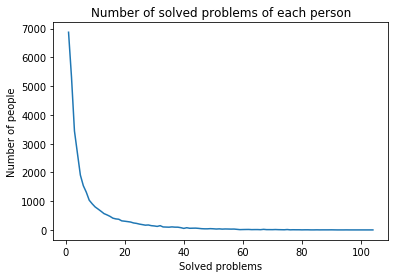

In [124]:
pd.Series(dict(pd.Series(list(user.values())).value_counts(sort = True, normalize = False))).plot( 
    title = "Number of solved problems of each person")
plt.xlabel("Solved problems")
plt.ylabel("Number of people")
plt.show()

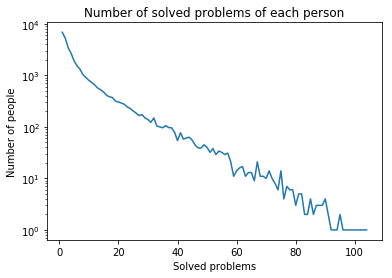

In [125]:
pd.Series(dict(pd.Series(list(user.values())).value_counts(sort = True, normalize = False))).plot( 
    title = "Number of solved problems of each person",logy = True)
plt.xlabel("Solved problems")
plt.ylabel("Number of people")
plt.show()

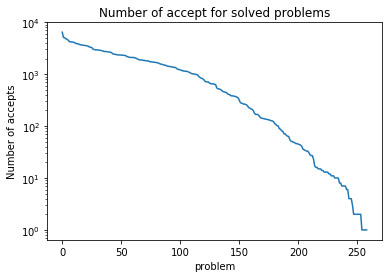

In [126]:
pd.Series( sorted( list(prb.values()) , reverse = True) ).plot( 
    title = "Number of accept for solved problems", logy = True)
plt.xlabel("problem")
plt.ylabel("Number of accepts")
plt.show()

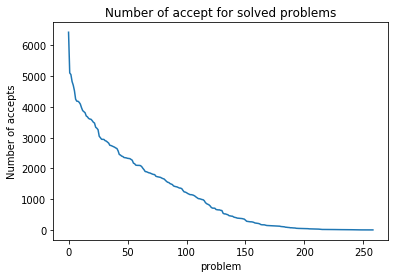

In [127]:
pd.Series( sorted( list(prb.values()) , reverse = True) ).plot( 
    title = "Number of accept for solved problems", logy = False)
plt.xlabel("problem")
plt.ylabel("Number of accepts")
plt.show()

### 开始给用户和题目标号

In [128]:
user_id = {}
cnt = 0

for i in user.keys():
    user_id[i]=cnt
    cnt = cnt+1

prb_id = {}
cnt = 0
for i in prb.keys():
    prb_id[i]=cnt
    cnt = cnt+1

ret = []
for index, row in df.iterrows():
    ret.append( [user_id[row["user_name"]], prb_id[row["prb_name"]], np.log(row["time"]) ] )

ret = pd.DataFrame(ret)
ret.columns = df.columns
df = ret

In [129]:
reader = Reader(rating_scale=(0, 6))
data = Dataset.load_from_df(df, reader)
trainset, testset = train_test_split(data, test_size=0.2)

* 评估获得答案并且评估结果

In [130]:
def evaluate(algo, trainset, testset):
    algo.fit(trainset)
    ret = algo.fit(trainset).test(testset)
    ret = pd.DataFrame(ret)
    delta = np.array(ret["r_ui"]) - np.array(ret["est"])
    print("MAE = " + str(np.mean(np.abs(delta))) )
    plt.hist(delta, bins = 100)
    f = np.array(ret["r_ui"]) / np.array(ret["est"])
    t = np.exp( np.array(ret["r_ui"]) ) / np.exp( np.array(ret["est"]) ) 
    d = np.exp( np.array(ret["r_ui"]) ) - np.exp( np.array(ret["est"]) ) 
    d = np.abs(d)
    print("for eps = 0.3 result:" + str( sum( (f<=1.3)&(f>=0.7)  ) / len(t) ))
    print("for eps1 = 0.3 eps2 = 2 : result:" + str( sum( (t<=1.3)&(t>=0.7)|(d<=2)  ) / len(t) ))
    return 

MAE = 0.494422096055874
for eps = 0.3 result:0.8006861063464837
for eps1 = 0.3 eps2 = 2 : result:0.4223327615780446


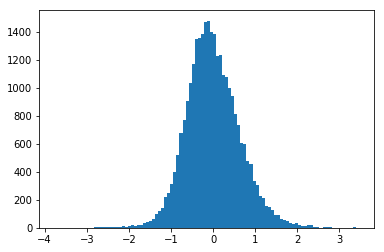

In [131]:
algo = SVD(n_factors = 100, n_epochs = 500, reg_all = 0.045);
evaluate(algo, trainset, testset)

MAE = 1.1432704551006478
for eps = 0.3 result:0.43036020583190393


c:\softwaress\tools\python3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


for eps1 = 0.3 eps2 = 2 : result:0.17869639794168096


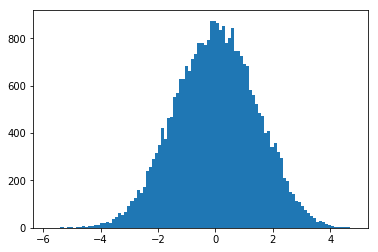

In [132]:
algo = NormalPredictor()
evaluate(algo, trainset, testset)

Estimating biases using als...
Estimating biases using als...
MAE = 0.5092777316084791
for eps = 0.3 result:0.7884391080617495
for eps1 = 0.3 eps2 = 2 : result:0.4152658662092624


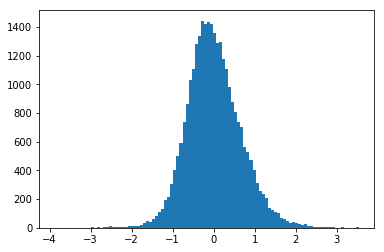

In [133]:
algo = BaselineOnly()
evaluate(algo, trainset, testset)

MAE = 0.4961404098984384
for eps = 0.3 result:0.7964665523156089
for eps1 = 0.3 eps2 = 2 : result:0.4299485420240137


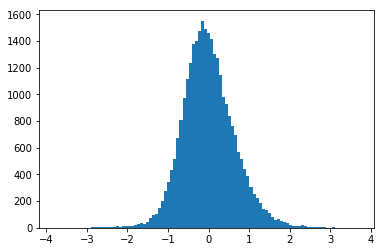

In [134]:
algo = SVD()
evaluate(algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
MAE = 0.547307140722702
for eps = 0.3 result:0.7564665523156089
for eps1 = 0.3 eps2 = 2 : result:0.39008576329331046


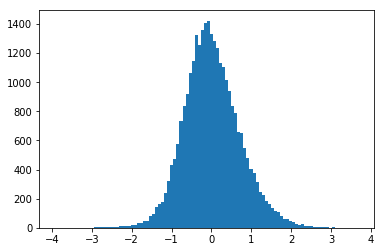

In [152]:
algo = KNNWithMeans()
evaluate(algo, trainset, testset)

# 最终为选手推荐题目，给出选手用户名，推荐前十道题

In [236]:
#获取需要的推荐
#fitted_algo 传入一个已经fit过的algo
#username 用户名
#expect_time 期望的做题时间
#problem_number 期望的题目数量
def get_suggest(fitted_algo, username, expect_time = 40, problem_number = 10):
    username = user_id[username];
    ept = np.log(expect_time)
    ans = []
    temp = list(prb_id.keys())
    for i in range(len(prb_id)):
        ret = pd.DataFrame([algo.predict(username, i, clip = False)])
        ans.append( tuple([np.abs(ret["est"][0] - ept) , temp[i]]) )
    ans = sorted(ans)
    ret = []
    for i in range(problem_number):
        ret+=[ans[i][1]]
    return ret;

In [231]:
algo=SVD()
algo.fit(trainset)

In [235]:
get_suggest(algo,"MATAB")

['Game with String',
 'Mahmoud and Ehab and the xor-MST',
 'Robot Vacuum Cleaner',
 'Substring',
 'Kuro and Walking Route',
 'Save Energy!',
 'Party Lemonade',
 'Riverside Curio',
 'Maximize!',
 'Stairs and Elevators']